** Step 1: Exploratory Data Analysis (EDA)**



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11904 entries, 0 to 11903
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           11904 non-null  object
 1   published_date  11904 non-null  object
 2   reporter        10914 non-null  object
 3   category        11904 non-null  object
 4   url             11904 non-null  object
 5   content         11904 non-null  object
dtypes: object(6)
memory usage: 558.1+ KB
None
                                               title  \
0  সিন নদীতে ব্যাপক দূষণ, স্থগিত করা হলো ট্রায়াথ...   
1             এসিসির নতুন সভাপতি হচ্ছেন মহসিন নাকভি!   
2  ২০৩০ ও ২০৩৪ বিশ্বকাপের হোস্ট জানা যাবে দুইদিন পর!   
3  প্যারিস অলিম্পিক: কোয়ার্টার ফাইনালে ওঠার লক্ষ্...   
4                আজ টিভিতে যা দেখবেন (৩০ জুলাই ২০২৪)   

             published_date reporter category                            url  \
0   30th July, 2024 5:59 pm   আরআইএম   sports  https://jamuna.tv/news/552127

/var/folders/nm/l7zhs8816hv5d_c6lvpbzn8m0000gn/T/ipykernel_22789/1749407327.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='category', palette='Set2')


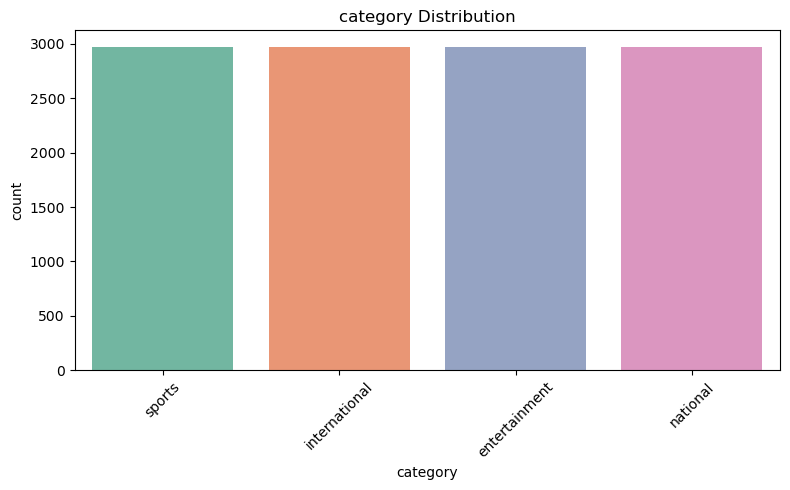

title               0
published_date      0
reporter          990
category            0
url                 0
content             0
dtype: int64


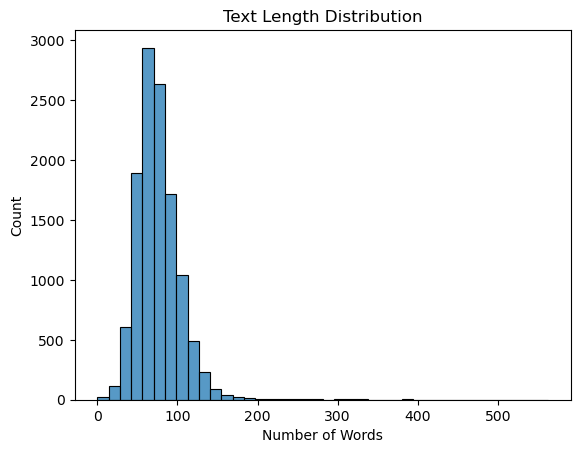

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/Users/md.jubayerhossain/Downloads/Bangla_news.csv")

# Basic info
print(df.info())
print(df.head())

print(df['category'].value_counts())

# Check category distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='category', palette='Set2')
plt.title("category Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check missing values
print(df.isnull().sum())

# Text length distribution
df['text_length'] = df['content'].astype(str).apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], bins=40)
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.show()


**Step 2: Data Preprocessing**

In [4]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Remove non-Bangla characters & stopwords
stop_words = set(stopwords.words('bengali'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^অ-ঔক-হড়-য়\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text.strip()

# Apply cleaning
df['clean_content'] = df['content'].apply(clean_text)
df.dropna(subset=['clean_content', 'category'], inplace=True)
df = df[df['clean_content'].str.strip() != '']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/md.jubayerhossain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Step 3: Feature Engineering (Label Encoding & Train-Test Split)**

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_content'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)


**Step 4: Model Creation (Transformer - BanglaBERT)**

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from tensorflow import keras

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

# Prepare datasets
train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_dataset = Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})

# Tokenization
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Load model
model = AutoModelForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=len(le.classes_))


The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


Map:   0%|          | 0/9521 [00:00<?, ? examples/s]

The OrderedVocab you are attempting to save contains holes for indices [1015, 1016, 1017, 1018, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1099, 1101, 1112, 1113, 1556, 1557, 1568], your vocabulary could be corrupted !


Map:   0%|          | 0/2381 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Step 5: Model Evaluation**

In [10]:
import evaluate
import numpy as np

# Load metrics once
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"],
        "precision": precision_metric.compute(predictions=preds, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=preds, references=labels, average="weighted")["recall"]
    }

Step 6: Model Tuning & **Training**


In [12]:
print(type(model))
print(len(train_dataset))
print(len(test_dataset))

<class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>
9521
2381


In [13]:
import transformers
print(transformers.__version__)

4.46.0


In [14]:
import numpy as np
import evaluate
from transformers import Trainer, TrainingArguments

# Load evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
        "precision": precision.compute(predictions=preds, references=labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="weighted")["recall"]
    }

# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # ← this works in your version
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=100
)

# Define Trainer
trainer = Trainer(
    model=model,                         # ← make sure your model is loaded
    args=training_args,
    train_dataset=train_dataset,         # ← make sure train_dataset is ready
    eval_dataset=test_dataset,           # ← make sure test_dataset is ready
    tokenizer=tokenizer,                 # ← ensure tokenizer is passed correctly
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate on test set
results = trainer.evaluate()
print("Evaluation results:", results)

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/nm/l7zhs8816hv5d_c6lvpbzn8m0000gn/T/ipykernel_22789/3909370750.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


RuntimeError: MPS backend out of memory (MPS allocated: 8.88 GB, other allocations: 98.67 MB, max allowed: 9.07 GB). Tried to allocate 96.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
# !pip uninstall -y transformers
# !pip install transformers==4.46

** Final Evaluation Report (Confusion Matrix, Classification Report)**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=-1)

# Report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


** ROC Curve (Multiclass One-vs-Rest)**

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=list(range(len(le.classes_))))
y_probs = torch.nn.functional.softmax(torch.tensor(preds.predictions), dim=1).numpy()

roc_auc = roc_auc_score(y_test_bin, y_probs, multi_class='ovr')
print("Multiclass ROC AUC Score:", roc_auc)
